# Using genes to predict traits with machine learning

In this notebook, we'll load in data from the NCBI associating species with Kegg Orthologs (KOs), and use it to train a classifier which can predict microbial traits from KOs, using the Python Scikit-Learn machine learning library.

First we import the python packages we'll need

In [1]:
import pandas as pd
import numpy as np
import re

#scikit-learn modules
from sklearn import ensemble, linear_model, metrics
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn import svm
from sklearn.preprocessing import StandardScaler

#plotting
from matplotlib import pyplot as plt
from matplotlib import style
style.use('ggplot')

%matplotlib inline

## Data preparation

In [2]:
#load in the features and labels data matrices

ko_matrix = pd.read_csv('datafiles/taxid_ko_matrix_all_full.csv').drop('Unnamed: 0',1)
func_matrix = pd.read_csv('datafiles/groups_to_records_all_full.txt',sep='\t', comment='#')

ko_matrix.columns = [re.sub('ko:','',i) for i in ko_matrix.columns]

#get lists of the KOs and functions for later use
ko_list = [i for i in list(ko_matrix.columns) if i.startswith('K')]
func_list = func_matrix.drop('record',1).columns

Type df.head() to look at the first few rows of any DataFrame df

In [3]:
ko_matrix.head()

,species_taxid,K00001,K00002,K00003,K00004,K00005,K00007,K00008,K00009,K00010,...,K17800,K17803,K17804,K17810,K17811,K17815,K17816,K17817,K17818,K17825
0,562,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2188,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38289,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,134821,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,632,0,0,0,0,0,1,1,1,2,...,0,0,0,0,0,0,0,0,0,0


In [4]:
len(ko_matrix)

9407

In [5]:
#merge the two files together based on the column 'species_taxid'
merged = pd.merge(ko_matrix, func_matrix, left_on='species_taxid', right_on='record')

merged.head()

,species_taxid,K00001,K00002,K00003,K00004,K00005,K00007,K00008,K00009,K00010,...,anoxygenic_photoautotrophy,oxygenic_photoautotrophy,photoautotrophy,aerobic_anoxygenic_phototrophy,photoheterotrophy,phototrophy,plastic_degradation,ureolysis,reductive_acetogenesis,chemoheterotrophy
0,562,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2188,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,38289,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,134821,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,632,0,0,0,0,0,1,1,1,2,...,0,0,0,0,0,0,0,0,0,0


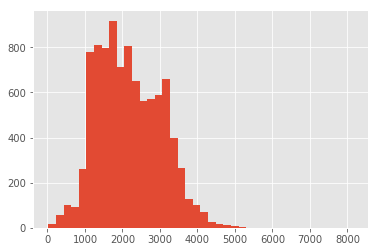

In [6]:
#histogram of total number of KOs in the different genomes
ko_sums = merged[ko_list].sum(axis=1)
ko_sums.hist(bins=40)

In [7]:
merged['sum'] = merged[ko_list].sum(axis=1)
merged.sort_values('sum')[['species_taxid','sum']].head()

,species_taxid,sum
2973,1094953,22
2985,1094946,52
3111,1268334,76
2976,1094930,95
3106,1298872,106


Now we prepare the data for training a classifier

In [8]:
#choose a function to train a classifier for
function = 'sulfate_respiration'

kos = merged[ko_list]
to_predict = merged[function]

#split the data into training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                                kos,to_predict, stratify=to_predict)

train_indices = X_train.index
test_indices = X_train.index

print('Training value counts: ',dict(y_train.value_counts()))
print('Testing value counts: ',dict(y_test.value_counts()))

Training value counts:  {0: 6937, 1: 118}
Testing value counts:  {0: 2313, 1: 39}


As a final preprocessing step, we need to normalize the features for logistic regression. We scale them so that all features have zero mean and unit variance. Note that we learn the means and variances from the training data only.

In [9]:
kos.shape

(9407, 9647)

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Training

In [11]:
#choose a classifier and fit it to the training data
#clf = ensemble.RandomForestClassifier()
#clf = svm.SVC(kernel='linear',probability=True, C=.05, class_weight=None)
clf = linear_model.LogisticRegression(penalty='l1', solver='liblinear',C=0.05,
                                     class_weight=None)
clf.fit(X_train,y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
#make predictions on the training and testing data

train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

#evaluate accuracy on the training and test data
print('Train acc: ', metrics.accuracy_score(y_train,train_predictions))
print('Test acc: ', metrics.accuracy_score(y_test,test_predictions))

Train acc:  0.999716513111
Test acc:  0.999149659864


Looks pretty good! But the accuracy can be misleading for unbalanced classes. Let's compute confusion matrices for a more detailed look.

In [13]:
print('Train: \n', metrics.confusion_matrix(y_train,train_predictions))
print('Test: \n', metrics.confusion_matrix(y_test,test_predictions))


Train: 
 [[6937    0]
 [   2  116]]
Test: 
 [[2313    0]
 [   2   37]]


The F1 score is another way to evaluate accuracy for unbalanced problems. It is the harmonic mean of precision (proportion of positive predictions which are correct) and recall (proportion of true positives found). 

In [14]:
print('Train F1: ', metrics.f1_score(y_train,train_predictions))
print('Test F1: ', metrics.f1_score(y_test,test_predictions))
print()
print('Train kappa: ', metrics.cohen_kappa_score(y_train,train_predictions))
print('Test kappa: ', metrics.cohen_kappa_score(y_test,test_predictions))

Train F1:  0.991452991453
Test F1:  0.973684210526

Train kappa:  0.991308868404
Test kappa:  0.973252362594


## The ROC curve

In [15]:
#make probabilistic predictions

train_probs = [i[1] for i in clf.predict_proba(X_train)]
test_probs = [i[1] for i in clf.predict_proba(X_test)]

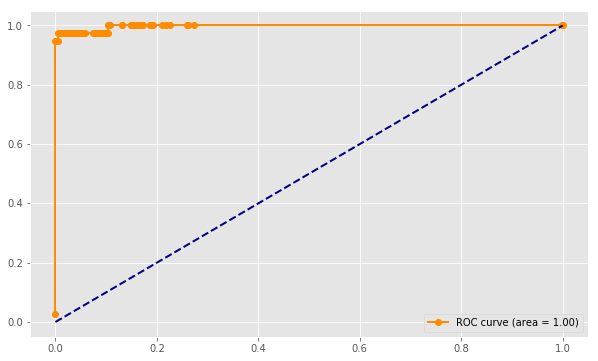

In [16]:
#compute and plot the ROC curve and area-under-curve score for the test set

roc_auc = metrics.roc_auc_score(y_test,test_probs)
tpr,fpr,_ = metrics.roc_curve(y_test,test_probs)

plt.figure(figsize=(10,6))
plt.plot(tpr, fpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc, marker='o')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc='lower right')


In [17]:
#use the ROC curve to pick an optimal cutoff value for the prediction to be positive

cutoff_value=0.5

test_predictions_better = np.array([1 if i>cutoff_value else 0 for i in test_probs])

print('Test acc: ', metrics.accuracy_score(y_test,test_predictions_better))
print('Test F1: ', metrics.f1_score(y_test,test_predictions_better))
print()
print('Test confusion matrix: \n', metrics.confusion_matrix(y_test,test_predictions_better))

Test acc:  0.999149659864
Test F1:  0.973684210526

Test confusion matrix: 
 [[2313    0]
 [   2   37]]


## Viewing the most predictive genes

We can look at the weights of the model we trained, to see which genes are important to making the prediction.

In [19]:
#load datafile containing descriptions of KEGG orthologs
ko_desc = pd.read_csv('datafiles/ko_definition.txt',sep='\t')

In [20]:
ko_df = pd.DataFrame([(i,j) for i,j in zip(ko_list,clf.coef_[0])])
ko_df.columns = ['ko','weight']
ko_df=ko_df.sort_values('weight',ascending=False)
ko_df = ko_df.merge(ko_desc,left_on='ko',right_on='ko')[['ko','weight','DEFINITION']]
ko_df.head(n=20)

,ko,weight,DEFINITION,PATHWAY
0,K16885,0.711401,"quinone-modifying oxidoreductase, subunit QmoA",NaN
1,K16887,0.239352,"quinone-modifying oxidoreductase, subunit QmoC",NaN
2,K11358,0.135824,aspartate aminotransferase [EC:2.6.1.1],"ko00220 Arginine biosynthesis;ko00250 Alanine,..."
3,K14127,0.103943,F420-non-reducing hydrogenase iron-sulfur subu...,NaN
4,K06951,0.099127,uncharacterized protein,NaN
5,K10302,0.082670,F-box protein 22,NaN
6,K11261,0.060976,formylmethanofuran dehydrogenase subunit E [EC...,ko00680 Methane metabolism;ko01200 Carbon meta...
7,K05299,0.058100,formate dehydrogenase alpha subunit [EC:1.2.1.43],ko00680 Methane metabolism;ko00720 Carbon fixa...
8,K09740,0.057935,uncharacterized protein,NaN
9,K07550,0.054558,benzoylsuccinyl-CoA thiolase BbsB subunit [EC:...,ko00623 Toluene degradation;ko01220 Degradatio...
